In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

The dataset contains the results of Black-hole--Wolf-Rayet (BH-WR) simulations at helium (he) or carbon (c) depletion according to the work of [Bavera et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...647A.153B/abstract).

Parameters:
- m_BH1: mass of the first-born BH in Msun
- m_WR: mass of the WR star in Msun
- p: orbital period in days
- metallicity: aboslute metalliciy Z
- m_BH2: mass of the second-born BH in Msun (from the collapse of the WR stellar profile at c depletion, see Appendix D of Bavera et al. 2021)
- a_BH2: dimensionless spin parameter of the second-bron BH

In [4]:
# load data
df = pd.read_csv("./BH-WR_dataset.csv.gz", compression="gzip")
df.head()

,metallicity,m_BH1_he_depletion,m_BH1_c_depletion,m_WR_he_depletion,m_WR_c_depletion,p_he_depletion,p_c_depletion,a_BH2,m_BH2
0,0.00176,11.665290,11.665290,11.406756,11.363704,6.826917,6.852466,2.225520e-08,8.188629
1,0.00021,29.394690,29.394690,7.933400,7.929318,8.028560,8.030316,1.123827e-08,3.247118
2,0.00258,4.629374,4.629374,32.684092,32.348911,1.038879,1.057793,3.542396e-02,31.848911
3,0.01437,2.500000,2.500000,11.834150,11.574917,9.016732,9.351918,2.991417e-08,8.059432
4,0.00457,2.500000,2.500000,14.596222,14.448331,0.545159,0.554705,3.210066e-01,13.946682


## Analytical approximation

In [24]:
def model(m_WR,p,state='c_depletion'): 
    if state == 'c_depletion':
        c1a = 0.051237
        c2a = 0.029928
        c3a = 0.282998
        c1b = 0.027090
        c2b = 0.010905
        c3b = 0.422213
    elif state == 'he_depletion':
        c1a = 0.059305
        c2a = 0.035552
        c3a = 0.270245
        c1b = 0.026960
        c2b = 0.011001
        c3b = 0.420739
    else:
        raise ValueError('state not supported!')
    
    # a_BH2(p >= 1) = 0 
    a_BH2 = np.zeros(len(p))
    
    def constant(m_WR, c1, c2, c3):
        return -c1/(c2+np.exp(-c3*m_WR))
    
    alpha = constant(m_WR[p<1.], c1a, c2a, c3a)
    beta = constant(m_WR[p<1.], c1b, c2b, c3b)
    a_BH2[p<1.] = alpha*np.log10(p[p<1.])**2+beta*np.log10(p[p<1.])
    
    return a_BH2

In [34]:
# compute median absolute error on the dataset
MAE = np.abs(df['a_BH2']-model(df['m_WR_c_depletion'],df['p_c_depletion'],state='c_depletion'))
print('Median absolute error any p:', round(np.median(MAE),3))
print('Median absolute error p<=1 day:', round(np.median(MAE[df['p_c_depletion']<=1.]),3))

Median absolute error any p: 0.001
Median absolute error p<=1 day: 0.038


## Plot dataset vs analytical approximation

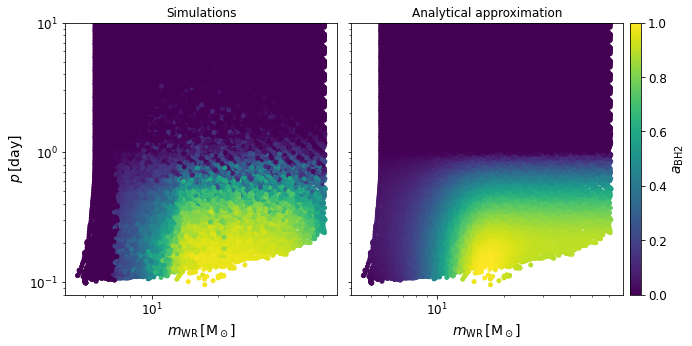

In [35]:
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05)

ax = fig.add_subplot(1, 2, 1)

sc1 = ax.scatter(df['m_WR_c_depletion'],
                 df['p_c_depletion'],
                 marker='.', linewidths=2, c=df['a_BH2'], 
                 vmin=0, vmax=1)

ax.set_title('Simulations')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$m_\mathrm{WR} \, [\mathrm{M}_\odot]$',fontsize=14)
ax.set_ylabel('$p \, [\mathrm{day}]$',fontsize=14)
ax.set_ylim(0.08,10)
ax.tick_params(axis='both', labelsize=12)

ax = fig.add_subplot(1, 2, 2)

ax.scatter(df['m_WR_c_depletion'],
           df['p_c_depletion'],
           marker='.', linewidths=2, 
           c=model(df['m_WR_c_depletion'],df['p_c_depletion'],state='c_depletion'), 
           vmin=0, vmax=1)

ax.set_title('Analytical approximation')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$m_\mathrm{WR} \, [\mathrm{M}_\odot]$',fontsize=14)
ax.set_ylim(0.08,10)
plt.tick_params(axis='y', labelleft=False)
ax.tick_params(axis='x', labelsize=12)

cbar_ax = plt.gcf().add_axes([0.91, 0.125, 0.015, 0.755])
plt.colorbar(sc1, cax=cbar_ax).set_label(label=r'$a_\mathrm{BH2}$', size=14)
cbar_ax.tick_params(labelsize=12) 